# Programación dinámica

El término *programación dinámica* (DP, *dynamic programming*) se refiere al conjunto de algoritmos usados para encontrar la política óptima en MDPs con un modelo del entrono perfectamente caracterizado. Este hecho, junto a que son computacionalmente exigentes, no los hace muy prácticos hoy en día, aún así siguen siendo interesantes desde un punto de vista teórico.

Los algoritmos de DP se basan en el uso de funciones de valor para organizar y estructurar la búsqueda de buenas políticas, utilizando las ecuaciones de optimidad de Bellman.

\begin{equation}
   v_*(s) = \max_a \sum_{s',r} p(s',r|s,a) [r + \gamma v_*(s')]
\end{equation}

\begin{equation}
   q_*(s,a) = \sum_{s',r} p(s',r|s,a) [r + \gamma \max_{a'} q_*(s',a')]
\end{equation}

## Evaluación de la política

Vamos a ver cómo calcular la función de valor $v_\pi$ para una política $\pi$ cualquiera, esto se llama *evaluación de la política*. 


\begin{equation}
   v_\pi(s) = \sum_a \pi(a|s) \sum_{s',r} p(s',r|s,a) [r + \gamma v_\pi(s')]
\end{equation}

donde $\pi(a|s)$ es la probabilidad de tomar la acción $a$ en el estado $s$ bajo la política $\pi$. Si las dinámicas del entrono son completamente conocidas, podemos utilizar un método de resolución iterativo

\begin{equation}
   v_{k+1}(s) = \sum_a \pi(a|s) \sum_{s',r} p(s',r|s,a) [r + \gamma v_k(s')]
\end{equation}

Cuando $k \rightarrow \infty$ entonces $v_k$ converge a $v_\pi$. Este algoritmo se conoce como *evaluación iterativa de la política*. Para cada paso iterativo, se aplica la misma operación en cada estado $s$ reemplazando el antigo valor por el nuevo.

Consideremos como ejemplo un entorno como el siguiente

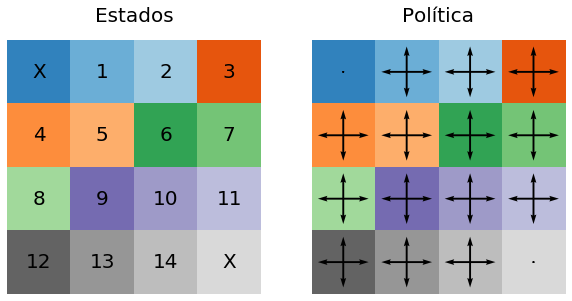

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_env(v, policy=None, title="$v_k$"):
    v = v.reshape(4,4)
    if policy is None:
        R, T = np.ones((4,4)), np.ones((4,4))
        L, B = -1.*R, -1.*T
    else:
        a = np.zeros((16,4))
        a[range(16),policy.argmax(axis=1)] = 1
        T = a[:,0].reshape((4,4))
        B = -1*a[:,1].reshape((4,4))
        R = a[:,2].reshape((4,4))
        L = -1*a[:,3].reshape((4,4))
    R[0,0], R[3,3] = 0, 0
    T[0,0], T[3,3] = 0, 0
    B[0,0], B[3,3] = 0, 0
    L[0,0], L[3,3] = 0, 0
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    zeros = np.zeros((4,4))
    ax1.matshow(v, cmap=plt.cm.tab20c)
    ax2.matshow(v, cmap=plt.cm.tab20c)
    for i in range(4):
        for j in range(4):
            c = v[j,i]
            if (i==0 and j==0) or (i==3 and j==3):
                ax1.text(i, j, 'X', va='center', ha='center', fontsize=20)
            else:
                ax1.text(i, j, f'{round(c,1)}', va='center', ha='center', fontsize=20)
    ax2.quiver(L, zeros, scale=10)
    ax2.quiver(R, zeros, scale=10)
    ax2.quiver(zeros, T, scale=10)
    ax2.quiver(zeros, B, scale=10)
    ax1.axis(False)
    ax1.set_title(title, fontsize=20)
    ax2.axis(False)
    ax2.set_title("Política", fontsize=20)
    plt.show()
    
estados = np.arange(16)
plot_env(estados, title="Estados")

El entrono se compone de 16 casillas, y en cada casilla nuestro agente puede tomar 1 acción de entre 4: subir, bajar, derecha o izquierda. Todas las acciones tienen una recompensa de -1, y el objetivo del agente es navegar el entorno para llegar a cualquiera de las dos casillas marcadas con una $X$.

In [32]:
def init_env():
    probas_transiciones = np.zeros((16,4,16))
    recompensas = -1*np.ones((16,4,16)) # todas a -1

    # acciones: 0 (arriba), 1 (abajo), 2 (derecha), 3(izquierda)
    for s in range(16):
        # arriba
        if s<4:
            probas_transiciones[s,0,s] = 1
        else:
            probas_transiciones[s,0,s-4] = 1
        # abajo
        if s<12:
            probas_transiciones[s,1,s+4] = 1
        else:
            probas_transiciones[s,1,s] = 1
        # derecha
        if (s+1) % 4 == 0:
            probas_transiciones[s,2,s] = 1
        else:
            probas_transiciones[s,2,s+1] = 1
        # izquierda
        if s % 4 == 0:
            probas_transiciones[s,3,s] = 1
        else:
            probas_transiciones[s,3,s-1] = 1

    # estados terminales
    probas_transiciones[0, :,:] = 0
    probas_transiciones[15, :,:] = 0
    recompensas[0,:,:] = 0
    recompensas[15,:,:] = 0
    
    return probas_transiciones, recompensas

In [33]:
def eval_pol(gamma=1, it=100):
    v = np.zeros(16)
    p = 0.25 # acciones equiprobables
    for iteration in range(it):
        v_prev = v.copy()
        for s in range(16):
            v[s] = np.sum([
                p*np.sum([
                    probas_transiciones[s][a][sp]*(recompensas[s][a][sp] + gamma*v_prev[sp]) 
                    for sp in range(16)
                ])
                for a in range(4)
            ])
    return v

In [34]:
def pol_optim(v, gamma=1):
    p = np.zeros((16, 4))
    for s in range(16):
        for a in range(4):
            p[s,a] = np.sum([
                    probas_transiciones[s][a][sp]*(recompensas[s][a][sp] + gamma*v[sp]) 
                    for sp in range(16)
                ])
    return p

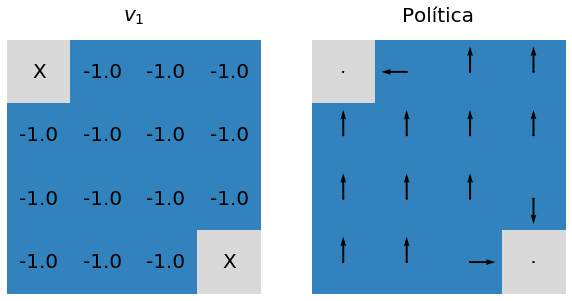

In [41]:
probas_transiciones, recompensas = init_env()
v = eval_pol(it=1)
p = pol_optim(v)
plot_env(v, p, title="$v_1$")

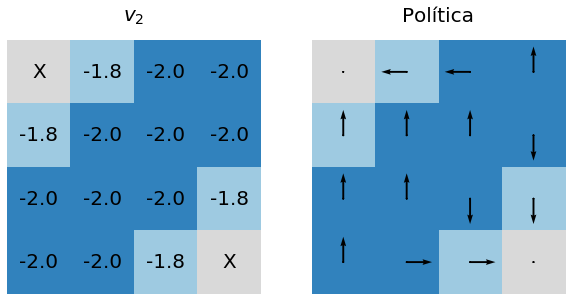

In [43]:
v = eval_pol(it=2)
p = pol_optim(v)
plot_env(v, p, title="$v_2$")

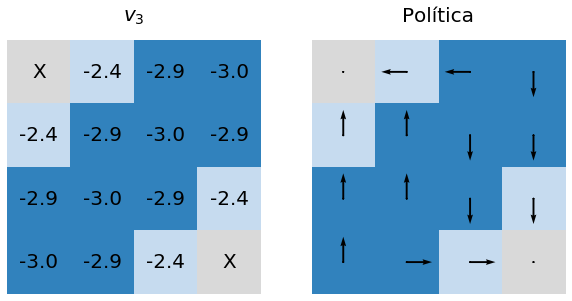

In [44]:
v = eval_pol(it=3)
p = pol_optim(v)
plot_env(v, p, title="$v_3$")

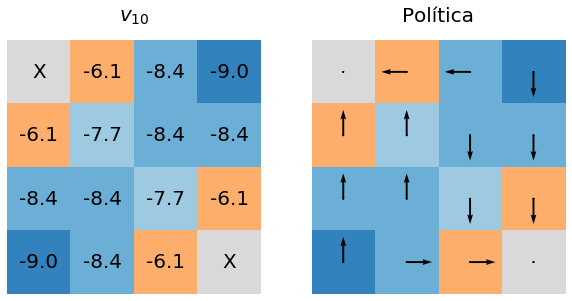

In [46]:
v = eval_pol(it=10)
p = pol_optim(v)
plot_env(v, p, title="$v_{10}$")

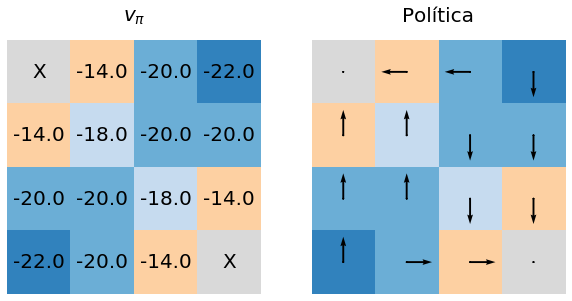

In [52]:
v = eval_pol(it=500)
p = pol_optim(v)
plot_env(v, p, title="$v_\pi$")

Como podemos ver las casillas con un valor más pequeño son aquellas que requieren más pasos para llegar a los estados terminales, y (en este caso en particular) la política final obtenida es la óptima.

## Mejora de la política

El motivo para calcular la función de valor de una política es poder encontrar políticas mejores. Imageinemos que hemos calculado la función de valor para una política determinística arbitraria $\pi$ y queremos saber si deberíamos escoger una acción $a \neq \pi(s)$. Para ello podemos considerar la nueva política

\begin{equation}
    \pi'(s) = \underset{a}{\arg\max}  \, q_\pi(s,a) = \underset{a}{\arg\max} \, \sum_{s',r} p(s',r|s,a) [r + \gamma v_\pi(s')]
\end{equation}

Escogiendo de manera *greedy* en cada estado aquella acción que maximiza el término de la derecha. Podemos entonces evaluar la función de valor de la nueva política, $v_{\pi'}$, y volver a mejorarla para encontrar $\pi''$, y así sucesivamente hasta encontrar la política óptima.

## Resumen

Hemos visto las ideas básicas de los algoritmos de programación dinámica y cómo resolver MDPs finitos. Hablamos de *evaluación de la política* cuando, de manera iterativa, calculamos la función de valor de una política determinada. Podemos mejorar la política escogiendo aquellas acciones que maximizen el retorno esperado con la función de valor evaluada anteriormente. Podemos ahora evaluar la función de valor de la nueva política y repetir el proceso hasta encontrar la política óptima.

Los métodos de programación dinámica operan haciendo un barrido de todo el espacio de estados, calculando el valor de cada estado basado en el valor de todos los posibles estados sucesivos ponderados por su probabilidad de ocurrir. Esto puede resultar en un factor limitador en aquellos casos en los que el número de estados sea muy grande (aunque técnicas como la *programación dinámica asíncrona* puede aliviar este problema en ocasiones).